# Bayesian methods for multilevel modelling

From [this tutorial](https://docs.pymc.io/notebooks/multilevel_modeling.html)

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from theano import tensor as tt
import arviz as az

In [2]:
RANDOM_SEED = 8924
np.random.seed(286)

## Radon contamination dataset  (Gelman and Hill 2006)

In [3]:
srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()  # Minnesota

Get county-level predictor of uranium

In [4]:
srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty = pd.read_csv(pm.get_data("cty.dat"))
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

Merge to combine home- and county-level information

In [5]:
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

In [6]:
n = len(srrs_mn)
n

919

In [7]:
srrs_mn

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,5995,MN,MN,27,55363,5,1,0,4,Y,...,122887,6.4,4.5,1146.499190,0,0,171,WRIGHT,27171,0.913909
923,5996,MN,MN,27,55376,5,1,0,7,Y,...,121987,4.5,8.3,1105.956867,0,0,171,WRIGHT,27171,0.913909
924,5997,MN,MN,27,55376,5,1,0,4,Y,...,13088,5.0,5.2,1214.922779,0,0,171,WRIGHT,27171,0.913909
925,5998,MN,MN,27,56297,5,1,0,4,Y,...,123087,3.7,9.6,1177.377355,0,0,173,YELLOW MEDICINE,27173,1.426590


In [8]:
len(srrs_mn['county'].unique())

85

Create a county index

In [9]:
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))

Finally, create local copies of variables

In [10]:
county = srrs_mn["county_code"] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor = srrs_mn.floor.values

## Conventional approaches

There are two conventional alternatives to modelling radon exposure. Let
- $y_i = $ Radon levels of home $i$
- $\alpha = $ county uranium level (pooled)
- $\alpha_{j[i]} = $ uranium level of county ($j$) corresponding to home $i$
- $x_i = $  measurement in basement or first floor

In [11]:
len(log_radon)

919

## Pooled model

**Complete pooling**

$$y_i =  \alpha + \beta x_i + \epsilon_i$$

In [12]:
coords = {"Level": ["Basement", "Floor"], "obs_id": np.arange(floor.size)}
with pm.Model(coords=coords) as pooled_model:
    floor_idx = pm.Data("floor_idx", floor, dims="obs_id")
    a = pm.Normal("a", 0.0, sigma=10.0, dims="Level")

    theta = a[floor_idx]
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")




Prior predictive checks

In [17]:
with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    idata_prior = az.from_pymc3(prior=prior_checks)

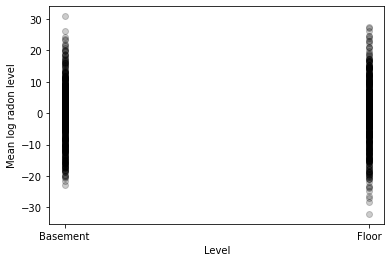

In [18]:
_, ax = plt.subplots()
idata_prior.prior.plot.scatter(x="Level", y="a", color="k", alpha=0.2, ax=ax)
ax.set_ylabel("Mean log radon level");

Do inference

In [19]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=RANDOM_SEED)
    pooled_idata = az.from_pymc3(pooled_trace)
az.summary(pooled_idata, round_to=2)

/home/juvid/miniconda3/envs/kolgraph_new/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


0, dim: obs_id, 919 =? 919
0, dim: obs_id, 919 =? 919


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.36,0.03,1.31,1.42,0.0,0.0,5391.74,3097.42,1.0
a[1],0.78,0.06,0.65,0.88,0.0,0.0,5718.40,3239.21,1.0
sigma,0.79,0.02,0.75,0.83,0.0,0.0,5986.40,2646.92,1.0


TODO: Learn what these statistics mean!

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

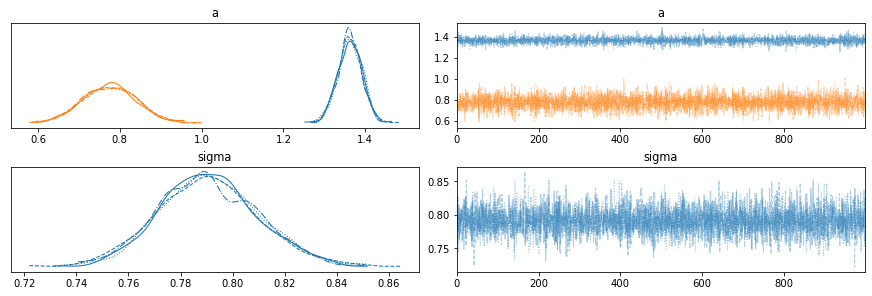

In [20]:
az.plot_trace(pooled_idata)

Do posterior predictive checks

In [21]:
with pooled_model:
    ppc = pm.sample_posterior_predictive(pooled_trace, random_seed=RANDOM_SEED)
    pooled_idata = az.from_pymc3(pooled_trace, posterior_predictive=ppc, prior=prior_checks)

0, dim: obs_id, 919 =? 919


In [22]:
pooled_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

Find highest density interval posterior predictive credible interval, of log radon levels for each floor

In [23]:
hdi_helper = lambda ds: az.hdi(ds, input_core_dims=[["chain", "draw", "obs_id"]])
hdi_ppc = (
    pooled_idata.posterior_predictive.y.groupby(pooled_idata.constant_data.floor_idx)
    .apply(hdi_helper)
    .y
)
hdi_ppc



<xarray.DataArray 'y' (floor_idx: 2, hdi: 2)>
array([[-0.13913155,  2.83724488],
       [-0.70807464,  2.278789  ]])
Coordinates:
  * hdi        (hdi) <U6 'lower' 'higher'
  * floor_idx  (floor_idx) int64 0 1

So indeed, radon levels are higher in basements as we expect

Plot the observed data on top of the HDI

In [24]:
level_labels = pooled_idata.posterior.Level[pooled_idata.constant_data.floor_idx]
pooled_idata.observed_data = pooled_idata.observed_data.assign_coords(Level=level_labels).sortby(
    "Level"
)

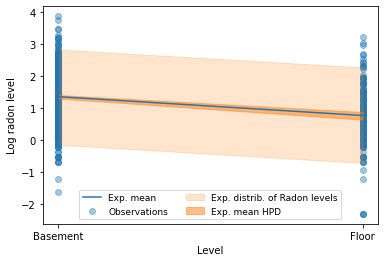

In [26]:
pooled_means = pooled_idata.posterior.mean(dim=("chain", "draw"))

_, ax = plt.subplots()
pooled_idata.observed_data.plot.scatter(x="Level", y="y", label="Observations", alpha=0.4, ax=ax)

az.plot_hdi(
    [0, 1],
    hdi_data=hdi_ppc,
    fill_kwargs={"alpha": 0.2, "label": "Exp. distrib. of Radon levels"},
    ax=ax,
)

az.plot_hdi(
    [0, 1], pooled_idata.posterior.a, fill_kwargs={"alpha": 0.5, "label": "Exp. mean HPD"}, ax=ax
)
ax.plot([0, 1], pooled_means.a, label="Exp. mean")

ax.set_ylabel("Log radon level")
ax.legend(ncol=2, fontsize=9, frameon=True);

## Unpooled model

**No pooling**

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

In [27]:
coords["County"] = mn_counties

In [32]:
with pm.Model(coords=coords) as unpooled_model:
    floor_idx = pm.Data("floor_idx", floor, dims="obs_id")
    county_idx = pm.Data("county_idx", county, dims="obs_id")
    
    a = pm.Normal("a", 0.0, sigma=10.0, dims=("County", "Level"))
    
    theta = a[county_idx, floor_idx]
    sigma = pm.Exponential("sigma", 1.0)
    
    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

In [33]:
with unpooled_model:
    unpooled_idata = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


0, dim: obs_id, 919 =? 919


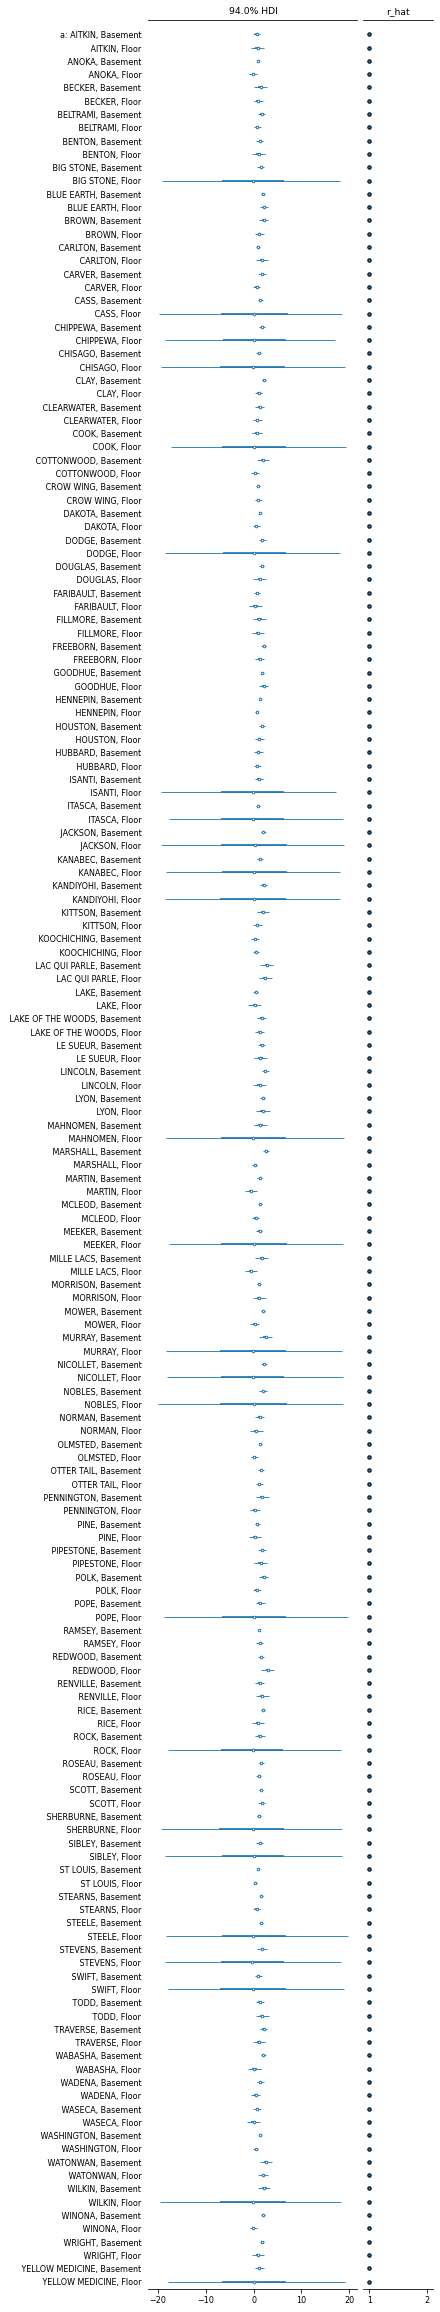

In [34]:
az.plot_forest(
    unpooled_idata, var_names="a", figsize=(6, 32), r_hat=True, combined=True, textsize=8
);